## Imports

In [1]:
import os
os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"
os.environ["ISIS3DATA"] = "/usgs/cpkgs/isis3/data"
from pysis import isis

from plio.io import io_controlnetwork
from knoten.csm import create_csm
from scipy import sparse
import ale
import csmapi
import numpy as np

import matplotlib.pyplot as plt

from knoten.bundle import *

/Users/jmapel/miniconda3/envs/knoten/lib/python3.7/site-packages/pysis/env.py:31: RuntimeWarning: Could not find isis. Is `ISISROOT` set?
  warnings.warn('Could not find isis. Is `ISISROOT` set?', RuntimeWarning)
/Users/jmapel/miniconda3/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning: ALESPICEROOT environment variable not set, Spice Drivers will not function correctly
  warnings.warn('ALESPICEROOT environment variable not set, Spice Drivers will not function correctly')


## Load Network and Generate Sensors

In [2]:
cubes = 'data/cubes.lis'
sensors = generate_sensors(cubes)

network = 'data/hand_dense.net'
cnet = io_controlnetwork.from_isis(network)
cnet = compute_apriori_ground_points(cnet, sensors) # autoseed did not generate ground points, calculate and repopulate the data frame

## Determine Which Sensor Parameters to Solve For

In [3]:
all_parameters = {sn: get_sensor_parameters(sensor) for sn, sensor in sensors.items()}
for sn, parameters in all_parameters.items():
    print(f"Image: {sn}")
    for param in parameters:
        print(f"  {param.name} | {param.index} | {param.value}")

Image: MRO/CTX/1085197697:073
  IT Pos. Bias    | 0 | 0.0
  CT Pos. Bias    | 1 | 0.0
  Rad Pos. Bias   | 2 | 0.0
  IT Vel. Bias    | 3 | 0.0
  CT Vel. Bias    | 4 | 0.0
  Rad Vel. Bias   | 5 | 0.0
  Omega Bias      | 6 | 0.0
  Phi Bias        | 7 | 0.0
  Kappa Bias      | 8 | 0.0
  Omega Rate      | 9 | 0.0
  Phi Rate        | 10 | 0.0
  Kappa Rate      | 11 | 0.0
  Omega Accl      | 12 | 0.0
  Phi Accl        | 13 | 0.0
  Kappa Accl      | 14 | 0.0
  Focal Bias      | 15 | 0.0
Image: MRO/CTX/1096561308:045
  IT Pos. Bias    | 0 | 0.0
  CT Pos. Bias    | 1 | 0.0
  Rad Pos. Bias   | 2 | 0.0
  IT Vel. Bias    | 3 | 0.0
  CT Vel. Bias    | 4 | 0.0
  Rad Vel. Bias   | 5 | 0.0
  Omega Bias      | 6 | 0.0
  Phi Bias        | 7 | 0.0
  Kappa Bias      | 8 | 0.0
  Omega Rate      | 9 | 0.0
  Phi Rate        | 10 | 0.0
  Kappa Rate      | 11 | 0.0
  Omega Accl      | 12 | 0.0
  Phi Accl        | 13 | 0.0
  Kappa Accl      | 14 | 0.0
  Focal Bias      | 15 | 0.0
Image: MRO/CTX/1136952576:186
  

In [4]:
# Solve for angles and angular rates
solve_parameters = {sn: params[6:12] for sn, params in all_parameters.items()}

## Compute the Column Indices for Parameters

In [5]:
column_dict = compute_coefficient_columns(cnet, sensors, solve_parameters)
# num_parameters = max(col_range[1] for col_range in column_dict.values())

## Compute the Weight Matrix
#### According to the weighted Normal equation (J.TWJ), W needs to be a square matrix the size of (# of measures)x2. So it is the weight of the observations. In ISIS, the weight of the observations are an inverted function of the size of the pixels on the focal plane (resolution). However, in csm we do not have access to that information. 
#### For the time being, since we are working exclusively with CTX images we are going to set the weight matrix equal to the identity matrix -> all observations have the same weight.

In [6]:
num_observations = 2 * len(cnet)
W_observations = np.eye(num_observations) # this is a place holder until Jesse adds his calculations
W_params = compute_parameter_weights(cnet, sensors, solve_parameters, column_dict)

## Calculate Initial Sigma0

In [7]:
V = compute_residuals(cnet, sensors)
dX = np.zeros(W_params.shape[0])
sigma0 = compute_sigma0(V, dX, W_params, W_observations)

print((sigma0))

4.204919720360203


## Populate Jacobian

In [8]:
J = compute_jacobian(cnet, sensors, solve_parameters, column_dict)

## Bundle Iteration

In [9]:
def bundle_iteration(J, V, W_parameters, W_observations):
    """
    Parameters
    ----------
    J  :  ndarray
          The Jacobian matrix
    V  :  np.array
          An array of residuals of the difference between registered measure 
          and back projected ground points in image space.
    W_parameters  :  ndarray 
                     The parameter weight matrix (i.e.: sensor parameters and point weights)
    W_observations  :  ndarray
                     The observation weight matrix (i.e.: measure weights)
    
    Returns
    -------
    N  :  np.ndarray
          Normal equation matrix 
    
    dX  :  np.ndarray
           An array of updated parameter values
    """
    
    N = J.T.dot(W_observations).dot(J) + W_parameters
    C = J.T.dot(W_observations).dot(V)
    dX = np.linalg.inv(N).dot(C)
    return N, dX

In [10]:
N, dX = bundle_iteration(J, V, W_params, W_observations)
print(dX.shape)

(129,)


## Calculate Updated Sigma0

In [11]:
dof = W_observations.shape[0] - W_params.shape[0]
updated_sigma0 = np.sqrt((V.dot(W_observations).dot(V) - dX.dot(J.T).dot(W_observations).dot(V))/dof)
print(updated_sigma0)

1.3539087789122572


## Redundancy Number

Minimum redundancy: 0.7265904546263113
Maximum redundancy: 0.9653252487512078


{'whiskers': [<matplotlib.lines.Line2D at 0x1377eeb10>,
 'caps': [<matplotlib.lines.Line2D at 0x1377fa5d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1377ee510>],
 'medians': [<matplotlib.lines.Line2D at 0x1378000d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x137800610>],
 'means': []}

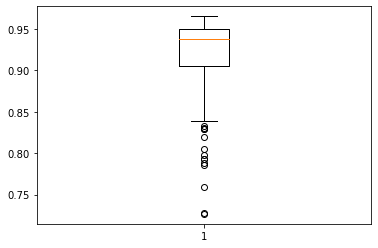

In [12]:
# redundancy for every measure
# vector will hold same order as the measures in the cnet df
# def compute_measure_redundancy
def compute_redundancy(N, W_observations, J):
    Qxx = np.linalg.inv(N)
    Qvv = np.linalg.inv(W_observations) - J.dot(Qxx).dot(J.T)
    r = np.diagonal(Qvv.dot(W_observations))
    
    return r

r = compute_redundancy(N, W_observations, J)
print(f'Minimum redundancy: {min(r)}')
print(f'Maximum redundancy: {max(r)}')
plt.boxplot(r)

## Whole bundle process in a loop

In [13]:
sensors = generate_sensors(cubes) # generate sensors
cnet = io_controlnetwork.from_isis(network) # load in network
cnet = compute_apriori_ground_points(cnet, sensors) # calculate ground points

### INPUTS ###
all_parameters = {sn: get_sensor_parameters(sensor) for sn, sensor in sensors.items()} #all parameters
parameters = {sn: parameter[:3] for sn, parameter in all_parameters.items()} #just solving for camera angles and angle velocity
##############

column_dict = compute_coefficient_columns(cnet, sensors, parameters)
num_parameters = max(col_range[1] for col_range in column_dict.values())
num_observations = 2 * len(cnet)
W_observations = np.eye(num_observations)
W_params = compute_parameter_weights(cnet, sensors, parameters, column_dict)

iteration = 0
V = compute_residuals(cnet, sensors)
dX = np.zeros(W_params.shape[0]) #initialize for sigma calculatioN
sigma0 = compute_sigma0(V, dX, W_params, W_observations)
print(f'iteration {iteration}: sigma0 = {sigma0}\n')

max_iterations = 10
tol = 1e-10
total_correction = np.zeros(num_parameters)
for i in range(max_iterations):   
    iteration += 1
    old_sigma0 = sigma0
    
    J = compute_jacobian(cnet, sensors, parameters, column_dict)    
    N = J.T.dot(W_observations).dot(J) + W_params # calculate the normal equation
    C = J.T.dot(W_observations).dot(V) - W_params.dot(total_correction)
    dX = np.linalg.inv(N).dot(C) #calculate change in camera parameters and ground points
    total_correction += dX
    print(f'corrections: mean = {dX.mean()} min = {dX.min()} max = {dX.max()}')
    
    update_parameters(sensors, parameters, cnet, dX, column_dict)
    
    V = compute_residuals(cnet, sensors)
    sigma0 = compute_sigma0(V, dX, W_params, W_observations)
    sigma0 = np.sqrt((V.dot(W_observations).dot(V) + dX.dot(W_params).dot(dX))/dof)
    print(f'iteration {iteration}: sigma0 = {sigma0}\n')
    
    if (abs(sigma0 - old_sigma0) < tol):
        print(f'change in sigma0 of {abs(sigma0 - old_sigma0)} converged!')
        break
    

iteration 0: sigma0 = 4.024624232958855

corrections: mean = 0.06068557941271087 min = -15.8172545055952 max = 43.17434302462997
iteration 1: sigma0 = 1.3972010678374138

corrections: mean = -9.858798532284902e-06 min = -0.0017681524505382047 max = 0.000797618490775309
iteration 2: sigma0 = 1.1672101436874192

corrections: mean = -4.883462007992103e-10 min = -3.027119455330832e-08 max = 3.8395021081293515e-08
iteration 3: sigma0 = 1.1672101426405515

corrections: mean = 1.9553807444358013e-11 min = -3.876795152995449e-09 max = 5.949235692857101e-09
iteration 4: sigma0 = 1.1672101426342938

change in sigma0 of 6.257661055997232e-12 converged!
